# Sentiment Analysis

## 필요한 모듈 import

In [2]:
import sys, os

import keras

sys.path.append(os.pardir)
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pickle
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 네이버 영화 리뷰 데이터 전처리
감성 분석기 학습을 네이버 영화 리뷰 데이터로 진행고자 함.

- 학습 데이터 : `./dataset/ratings_train.txt`
- 평가 데이터 : `./dataset/ratings_test.txt`

In [3]:
# 네이버 영화 리뷰 데이터 로드
train_data = pd.read_table('./dataset/ratings_train.txt')
test_data = pd.read_table('./dataset/ratings_test.txt')

In [4]:
# 네이버 영화 리뷰 데이터 정제
train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련 샘플의 개수 :',len(train_data))

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

<ipython-input-4-34988b439264>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
<ipython-input-4-34988b439264>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 훈련 샘플의 개수 : 145393
전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-4-34988b439264>:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
<ipython-input-4-34988b439264>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [5]:
# 토큰화와 제거
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

# 형태소 분석기를 사용하여 토큰화를 진행하면서 불용어를 제거
okt = Okt()
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [14]:
with open('stopwords.pickle', 'wb') as myfile:
    pickle.dump(stopwords, myfile)

In [6]:
# y_train, y_test 생성
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [7]:
# X_train, y_train, X_test, y_test을 pickle파일로 저장 (이후 간편한 테스트를 위함)
with open('X_train_complete_tokenization.pickle', 'wb') as myfile:
    pickle.dump(X_train, myfile)

with open('y_train_complete_tokenization.pickle', 'wb') as myfile:
    pickle.dump(y_train, myfile)

with open('X_test_complete_tokenization.pickle', 'wb') as myfile:
    pickle.dump(X_test, myfile)

with open('y_test_complete_tokenization.pickle', 'wb') as myfile:
    pickle.dump(y_test, myfile)


## 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 한다.

정수 인코딩을 수행하기 위해 **단어 집합(vocaburary)**이 필요한데, X_train 데이터를 이용하여 단어 집합을 생성할것이다.

단, X_train 데이터(네이버 영화 리뷰 데이터)에서 **빈도수가 낮은 단어들은 자연어 처리에서 배제**하고자 한다.

In [8]:
# X_train, y_train, X_test, y_test 로딩
with open('X_train_complete_tokenization.pickle', 'rb') as myfile:
    X_train = pickle.load(myfile)

with open('y_train_complete_tokenization.pickle', 'rb') as myfile:
    y_train = pickle.load(myfile)

with open('X_test_complete_tokenization.pickle', 'rb') as myfile:
    X_test = pickle.load(myfile)

with open('y_test_complete_tokenization.pickle', 'rb') as myfile:
    y_test = pickle.load(myfile)


In [14]:
# X_train 데이터로 단어 집합 생성
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 단어 집합 확인
# print(tokenizer.word_index)

# 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
threshold = 3
total_cnt = len(tokenizer.word_index) # 전체 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)를 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 3번 미만인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


확인 결과 전체 등장 빈도에서 희귀 단어(등장 빈도가 3회 미만인 단어)가 등장하는 비율은 대략 1.87% 수준으로 단어 집합에서 제외해도 좋다고 판단했다.

희귀 단어를 제외한 단어 집합을 만든 뒤 언제나 사용할 수 있게 pickle 파일로 직렬화 한다.

In [15]:
# 등장 빈도가 3회 미만인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한한다.
# 0번 패딩 토큰을 고려하여 + 1 해준다.
vocab_size = total_cnt - rare_cnt + 1
print('vocaburary size : ', vocab_size)

# 단어 집합 생성
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

# pickle 파일로 저장
with open('vocab_size.pickle', 'wb') as myfile:
    pickle.dump(vocab_size, myfile)

with open('tokenizer.pickle', 'wb') as myfile:
    pickle.dump(tokenizer, myfile)

vocaburary size :  19416


pickle 파일로 저장한 tokenizer를 불러와 X_train과 X_test 정수 인코딩을 진행한다.

In [16]:
# 단어 집합 불러오기
with open('tokenizer.pickle', 'rb') as myfile:
    tokenizer = pickle.load(myfile)

# X_train과 X_test 정수 인코딩
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print(X_train[:1])

[[50, 454, 16, 260, 659]]


전체 데이터에서 빈도수가 낮은 단어를 삭제하는 과정에서 빈 샘플이 생성된다.

빈 샘플들은 어떤 레이블이 붙어있건 의미가 없으므로 빈 샘플들을 제거해주는 작업을 진행한다.

In [17]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아온다
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

145162
145162


C:\Users\pc\.conda\envs\sentiment_analysis\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있다.

우선 전체 데이터에서 전체 데이터의 길이 분포를 확인한다.

max length :  69
average length :  10.812485361182679


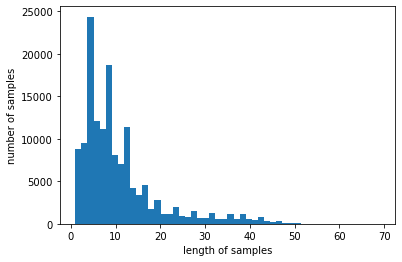

In [18]:
print('max length : ', max(len(i) for i in X_train))
print('average length : ', sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

차트로 확인해 봤을 때 전체 데이터의 길이 분포는 대략 11내외의 길이를 갖는다.

특정 길이 변수를 `max_len`으로 정하고, 전체 샘플 주 길이가 `max_len`이하인 샘플의 비율이 몇 %인지 확인해 본다.

In [19]:
# 전체 샘플 중 길이가 max_len이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [20]:
max_len = 30
below_threshold_len(max_len, X_train)

max_len = 40
below_threshold_len(max_len, X_train)

max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003
전체 샘플 중 길이가 40 이하인 샘플의 비율: 98.38043014011932
전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.94006695967265


길이가 40 이하인 샘플의 비율은 98% 이상으로 대부분의 샘플을 커버한다.

앞으로 감성 분석기에 사용할 데이터는 길이 40으로 맞춰주기로 결정했다.

In [21]:
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [22]:
# 완성된 데이터셋 저장
with open('X_train.pickle', 'wb') as myfile:
    pickle.dump(X_train, myfile)

with open('y_train.pickle', 'wb') as myfile:
    pickle.dump(y_train, myfile)

with open('X_test.pickle', 'wb') as myfile:
    pickle.dump(X_test, myfile)

with open('y_test.pickle', 'wb') as myfile:
    pickle.dump(y_test, myfile)

## 감성 분석 모델 생성

In [5]:
import pickle
# 데이터셋 로딩
with open('X_train.pickle', 'rb') as myfile:
    X_train = pickle.load(myfile)

with open('y_train.pickle', 'rb') as myfile:
    y_train = pickle.load(myfile)

with open('X_test.pickle', 'rb') as myfile:
    X_test = pickle.load(myfile)

with open('y_test.pickle', 'rb') as myfile:
    y_test = pickle.load(myfile)

with open('vocab_size.pickle', 'rb') as myfile:
    vocab_size = pickle.load(myfile)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# 임베딩 벡터의 차원은 100, 리뷰 분류를 위해 LSTM 사용
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 테스트 데이터 손실(val_loss)가 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 이상 증가하면 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4
)
mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True
)

lrr = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)


model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

# epoch는 20번 수행, 훈련 데이터 중 20%를 검증 데이터로 사용
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=60,
    validation_split=0.2,
    callbacks=[es, mc, lrr]
)


Epoch 1/20
1936/1936 [==============================] - 35s 17ms/step - loss: 0.3879 - acc: 0.8242 - val_loss: 0.3561 - val_acc: 0.8441

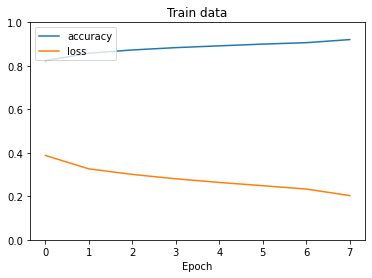

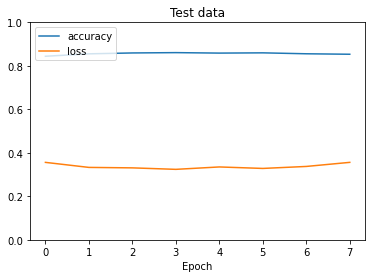

In [9]:
# plot
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Train data')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('Test data')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [10]:
# 테스트 데이터로 정확도 측정
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_test, y_test)

1527/1527 [==============================] - 8s 5ms/step - loss: 0.3337 - acc: 0.8574

[0.3337101340293884, 0.8573855757713318]

## 리뷰 예측 함수

In [12]:
import sys, os

import keras

sys.path.append(os.pardir)
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pickle
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
max_len = 40
with open('tokenizer.pickle', 'rb') as myfile:
    tokenizer = pickle.load(myfile)
loaded_model = load_model('best_model.h5')

def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))

In [13]:
sentiment_predict('기분이 안좋다')

6.19% 확률로 긍정 리뷰입니다.



# 실제 데이터로 전이학습 해보기

<ipython-input-3-6fa058d8c078>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  labeled_data['body'] = labeled_data['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
<ipython-input-3-6fa058d8c078>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  labeled_data['body'] = labeled_data['body'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 998
Epoch 1/20
80/80 [==============================] - 4s 17ms/step - loss: 0.4304 - acc: 0.8383 - val_loss: 0.2286 - val_acc: 0.9550 - ETA: 0s - loss: 0.4723 - acc: 0.8429

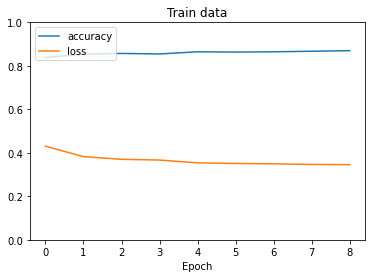

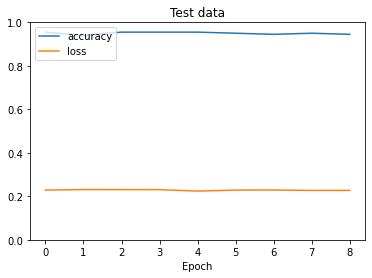

In [3]:
import sys, os
sys.path.append(os.pardir)
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import pickle
from konlpy.tag import Okt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.layers import Embedding, Dense, LSTM, RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 데이터 로드
labeled_data = pd.read_excel('./dataset/recent_comment_1000.xlsx')

# 데이터 전처리
labeled_data['body'] = labeled_data['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
labeled_data['body'] = labeled_data['body'].str.replace('^ +', "") # 공백은 empty 값으로 변경
labeled_data['body'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
labeled_data = labeled_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(labeled_data))

# 토큰화
okt = Okt()
with open('stopwords.pickle', 'rb') as myfile:
    stopwords = pickle.load(myfile)

X_train = []
for sentence in labeled_data['body']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

y_train = np.array(labeled_data['label'])

# 정수 인코딩
with open('tokenizer.pickle', 'rb') as myfile:
    tokenizer = pickle.load(myfile)

X_train = tokenizer.texts_to_sequences(X_train)

# 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)

# 전이 학습
# 기본 모델 로딩
base_model = load_model('best_model.h5')

base_model.layers[0].trainable = False
base_model.layers[1].trainable = False
base_model.layers[2].trainable = False

model = Sequential()
model.add(base_model.layers[0])
model.add(base_model.layers[1])
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 테스트 데이터 손실(val_loss)가 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 이상 증가하면 조기 종료(Early Stopping)
# ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4
)
mc = ModelCheckpoint(
    'best_transfer_model.h5',
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True
)

lrr = ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1,
    factor=0.25,
    min_lr=0.0000001
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

# epoch는 20번 수행, 훈련 데이터 중 20%를 검증 데이터로 사용
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=10,
    validation_split=0.2,
    callbacks=[es, mc, lrr]
)

plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('Train data')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.title('Test data')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()


In [4]:
# 실제 200개 데이터로 성능 측정
# 데이터 로드
labeled_data = pd.read_csv('./dataset/comment_labeled.CSV')

# 데이터 전처리
labeled_data['body'] = labeled_data['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
labeled_data['body'] = labeled_data['body'].str.replace('^ +', "") # 공백은 empty 값으로 변경
labeled_data['body'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
labeled_data = labeled_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(labeled_data))

# 토큰화
X_test = []
for sentence in labeled_data['body']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

y_test = np.array(labeled_data['label'])

# 정수 인코딩
with open('tokenizer.pickle', 'rb') as myfile:
    tokenizer = pickle.load(myfile)

X_test = tokenizer.texts_to_sequences(X_test)

# 패딩
max_len = 40
X_test = pad_sequences(X_test, maxlen=max_len)

# 성능 측정 (기본 모델)
loaded_model = load_model('best_model.h5')
print(loaded_model.evaluate(X_test, y_test))

# 성능 측정 (전이 학습)
loaded_model = load_model('best_transfer_model.h5')
print(loaded_model.evaluate(X_test, y_test))

<ipython-input-4-5ae0dad32a96>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  labeled_data['body'] = labeled_data['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식으로 한글만 남기고 나머지 제거
<ipython-input-4-5ae0dad32a96>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  labeled_data['body'] = labeled_data['body'].str.replace('^ +', "") # 공백은 empty 값으로 변경


전처리 후 테스트용 샘플의 개수 : 199
7/7 [==============================] - 1s 6ms/step - loss: 0.3778 - acc: 0.8241
[0.37776514887809753, 0.8241205811500549]
7/7 [==============================] - 1s 5ms/step - loss: 0.2292 - acc: 0.9447
[0.22917863726615906, 0.9447236061096191]
